# **Getting started with TensorFlow**

**Learning objectives**

1. Practice defining and performing basic operations on tensors
2. Use TensorFlow automatic differentiation capability
3. Learn how to train a linear regression from scratch with TensorFlow

In this notebook, we will start by reviewing the main operations on tensors in TensorFlow and understand how to manipulate TensorFlow Variables. We explain how these are compatible with Python built-in `list` and NumPy `array` objects.

Then we will jump to the problem of training a linear regression from scratch with gradient descent. The first order of business will be to understand how to compute the gradients of a function (a loss function here) with respect to some of its arguments (the model weights here). The TensorFlow construct allowing us to do that is `tf.GradientTape`, which we will describe.

At last we will create a simple training loop to learn the weights of a 1-dim linear regression using synthetic data generated from a linear model.

As a bonus exercise, we will do the same for data generated from a non-linear model, forcing us to manual-engineer non-linear features to improve our linear model performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.4.1


## **Operations on tensors**

### **Variables and constants**

Tensors in TensorFlow are either **constants** (`tf.constant`) or **variables** (`tf.Variable`). Constant values cannot be changed, while variable values can be.

The main difference is that instances of `tf.Variable` have methods allowing us to change their values while tensors constructed with `tf.constant` don't have these methods, and therefore their values cannot be changed. When you want to change the value of a `tf.Variable` `x` use one of the following methods:

- `x.assign(new_value)`
- `x.assign_add(value_to_be_added)`
- `x.assign_sub(value_to_be_subtracted)`

In [2]:
x = tf.constant([2, 3, 4])
x

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 3, 4], dtype=int32)>

In [3]:
x = tf.Variable(2.0, dtype=tf.float32, name="my_variable")

In [4]:
x.assign(45.8)
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=45.8>

In [5]:
x.assign_add(4)
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=49.8>

In [6]:
x.assign_sub(49.8)
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=0.0>

### **Point-wise operations**

TensorFlow offers similar point-wise tensor operations as NumPy does:

- `tf.add` allows to add the components of a tensor
- `tf.multiply` allows to multiply the components of a tensor
- `tf.subtract` allows to subtract the components of a tensor
- `tf.math.*` contains the usual `math` operations to be applied on the components of a tensor

Most of the standard arithmetic ops (`tf.add`, `tf.subtract`, etc.) are overloaded by the usual corresponding arithmetic symbols (`+`, `-`, `*`, etc.)

In [8]:
a = tf.constant([5, 3, 8])
b = tf.constant([3, -1, 2])
c = tf.add(a, b)
d = a + b

print("c:", c)
print("d:", d)

c: tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)
d: tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)


In [9]:
a = tf.constant([5, 3, 8])
b = tf.constant([3, -1, 2])
c = tf.multiply(a, b)
d = a * b

print("c:", c)
print("d:", d)

c: tf.Tensor([15 -3 16], shape=(3,), dtype=int32)
d: tf.Tensor([15 -3 16], shape=(3,), dtype=int32)


In [10]:
# tf.math.exp expects floats so we need to explicitely give the type
a = tf.constant([5, 3, 8], dtype=tf.float32)
b = tf.math.exp(a)

print("b:", b)

b: tf.Tensor([ 148.41316    20.085537 2980.958   ], shape=(3,), dtype=float32)


### **Point-wise operations**

In addition to naive TensorFlow tensors, tensorflow operations can take native Python types and NumPy `array` operands.

In [13]:
# Native Python lists
a_py = [1, 2]
b_py = [3, 4]

tf.add(a_py, b_py)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

In [14]:
# NumPy arrays
a_np = np.array([1, 2])
b_np = np.array([3, 4])

tf.add(a_np, b_np)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([4, 6])>

In [15]:
# Native TensorFlow tensors
a_tf = tf.constant([1, 2])
b_tf = tf.constant([3, 4])

tf.add(a_tf, b_tf)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

You can convert a native TensorFlow tensor to a NumPy array using `.numpy()`.

In [16]:
a_tf.numpy()

array([1, 2], dtype=int32)

## **Linear Regression**

Now let's use low level TensorFlow operations to implement linear regression.

### **Toy Dataset**

We'll model the following function

$$
y = 2x + 10
$$

In [17]:
X = tf.constant(range(10), dtype=tf.float32)
Y = 2 * X + 10

print("X: {}".format(X))
print("Y: {}".format(Y))

X: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Y: [10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]


Let's also create a test data set to evaluate our models:

In [19]:
X_test = tf.constant(range(10, 20), dtype=tf.float32)
Y_test = 2 * X_test + 10

print("X_test: {}".format(X_test))
print("Y_test: {}".format(Y_test))

X_test: [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
Y_test: [30. 32. 34. 36. 38. 40. 42. 44. 46. 48.]


### **Loss function**

The simplest model we can build is a model that for each value of `x` returns the sample mean of the training set:

In [50]:
def predict_mean(X):
    y_hat = [Y.numpy().mean()] * len(X)
    return y_hat

Y_hat = predict_mean(X_test)    

Using *Mean Squared Error* as the error function, our loss is

$$
\text{MSE} = \frac{1}{m}\sum_{i=1}^m(\hat{Y}_i - Y_i)^2
$$

For our simple model the loss is then:

In [51]:
loss = tf.reduce_mean((Y_hat - Y)**2)
loss.numpy()

33.0

This very bad value for the MSE loss above will give us a baseline to compare how a more complex model is doing.

Now, if $\hat{Y}$ represents the vector containing our model predictions when we use a linear regression model, then we have:

$$
\hat{Y} = w_0X + w_1
$$

we can write a loss function taking as arguments the coefficients (or parameters) of the model:

In [26]:
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    return tf.reduce_mean((Y_hat - Y)**2)

### **Gradient function**

To use gradient descent we need to take the partial derivatives of the loss function with respect to each of the weights. We could manually compute the derivatives, but with TensorFlow automatic differentiation capabilities we don't have to!

During gradient descent **we think of the loss as a function of the parameters $w_0$ and $w_1$**. Thus, we want to compute the derivatives with respect to these variables.

For that we need to wrap our loss computation within the context of `tf.GradientTape` instance which will record gradient information.

```
with tf.GradientTape() as tape:
    loss = # loss computation
```

This will allow us to later compute the gradients of any tensor computed within the `tf.GradientTape` context with respect to instances of `tf.Variable`

```
gradients = tape.gradient(loss, [w0, w1])
```

Let's illustrate this procedure by computing the gradient of the loss function with respect to the model weights:

In [27]:
def compute_gradients(X, Y, w0, w1):
    with tf.GradientTape() as tape:
        loss = loss_mse(X, Y, w0, w1)
    return tape.gradient(loss, [w0, w1])

In [28]:
w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dw0, dw1 = compute_gradients(X, Y, w0, w1)

In [31]:
print("dw0:", dw0.numpy())
print("dw1:", dw1.numpy())

dw0: -204.0
dw1: -38.0


### **Training loop**

Here we have a very simple training loop that converges. Note we are ignoring best practices like batching, creating a separate test set, and random weight initialisation for the sake of simplicity.

In [42]:
STEPS = 1000
LEARNING_RATE = 0.02

w0 = tf.Variable(0, dtype=tf.float32)
w1 = tf.Variable(0, dtype=tf.float32)

for step in range(STEPS):
    # Calculate the gradients
    dw0, dw1 = compute_gradients(X, Y, w0, w1)
    
    # Update weights
    w0.assign_sub(dw0*LEARNING_RATE)
    w1.assign_sub(dw1*LEARNING_RATE)
    
    # Periodically print MSE
    if step % 100 == 0:
        mse = loss_mse(X, Y, w0, w1)
        print("STEP: {} MSE: {} w0: {} w1: {}\n".format(step, mse, w0.numpy(), w1.numpy()))
    
# Print final MSE and weights
print("LAST STEP:{} FINAL MSE: {} Final w0: {} Final w1: {}".format(step, mse, w0.numpy(), w1.numpy()))

STEP: 0 MSE: 35.70719528198242 w0: 4.079999923706055 w1: 0.7599999904632568

STEP: 100 MSE: 2.6017532348632812 w0: 2.4780430793762207 w1: 7.002389907836914

STEP: 200 MSE: 0.26831889152526855 w0: 2.153517961502075 w1: 9.037351608276367

STEP: 300 MSE: 0.027671903371810913 w0: 2.0493006706237793 w1: 9.690855979919434

STEP: 400 MSE: 0.0028539239428937435 w0: 2.0158326625823975 w1: 9.90071964263916

STEP: 500 MSE: 0.0002943490108009428 w0: 2.005084753036499 w1: 9.96811580657959

STEP: 600 MSE: 3.0356444767676294e-05 w0: 2.0016329288482666 w1: 9.989760398864746

STEP: 700 MSE: 3.1322738323069643e-06 w0: 2.0005245208740234 w1: 9.996710777282715

STEP: 800 MSE: 3.2238213520940917e-07 w0: 2.0001683235168457 w1: 9.998944282531738

STEP: 900 MSE: 3.369950718479231e-08 w0: 2.000054359436035 w1: 9.999658584594727

LAST STEP:999 FINAL MSE: 3.369950718479231e-08 Final w0: 2.0000178813934326 Final w1: 9.999887466430664


Now let's compare the test loss for this linear regression model to the test loss from the baseline model that outputs always the mean of the test set.

In [55]:
loss_pred_mean = tf.reduce_mean((predict_mean(X_test) - Y_test)**2)
loss_pred_mean.numpy()

433.0

In [56]:
loss = loss_mse(X_test, Y_test, w0, w1)
loss.numpy()

2.4155089e-08

This is indeed much better!

## **Non-linear regression**

Try modelling a non-linear function such as $y=xe^{-x^2}$

### **Toy data set**

In [57]:
X = tf.constant(np.linspace(0, 2, 1000), dtype=tf.float32)
Y = X * tf.exp(-X**2)

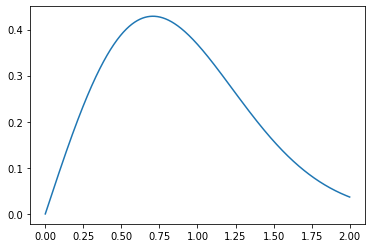

In [61]:
%matplotlib inline

plt.plot(X, Y);

In [68]:
def make_features(X):
    f1 = tf.ones_like(X) # Bias term
    f2 = X
    f3 = tf.square(X)
    f4 = tf.sqrt(X)
    f5 = tf.exp(X)
    return tf.stack([f1, f2, f3, f4, f5], axis=1)

In [63]:
def predict(X, W):
    return tf.squeeze(X @ W, -1)

### **Loss function**

In [65]:
def loss_mse(X, Y, W):
    return tf.reduce_mean((predict(X, W) - Y)**2)

### **Gradient function**

In [66]:
def compute_gradients(X, Y, W):
    with tf.GradientTape() as tape:
        loss = loss_mse(Xf, Y, W)
    return tape.gradient(loss, W)

### **Training loop**

STEP: 2000 MSE: 0.0023767943494021893


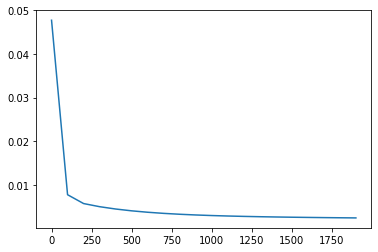

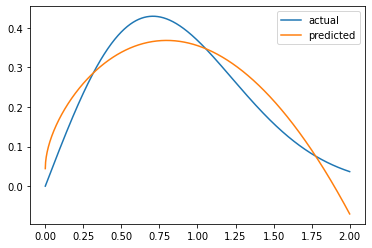

In [79]:
STEPS = 2000
LEARNING_RATE = 0.02

Xf = make_features(X)
n_weights = Xf.shape[1]

W = tf.Variable(np.zeros((n_weights, 1)), dtype=tf.float32)

# For plotting
steps, losses = [], []
plt.figure()

for step in range(STEPS):
    dW = compute_gradients(X, Y, W)
    W.assign_sub(dW * LEARNING_RATE)
    
    if step % 100 == 0:
        loss = loss_mse(Xf, Y, W)
        steps.append(step)
        losses.append(loss)
        plt.clf()
        plt.plot(steps, losses);

print("STEP: {} MSE: {}".format(STEPS, loss_mse(Xf, Y, W)))

plt.figure()
plt.plot(X, Y, label="actual")
plt.plot(X, predict(Xf, W), label="predicted")
plt.legend();